In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as scp
import scipy.integrate
import scipy.optimize

import pymc as pm
import arviz as az
import corner
sns.set('talk')
# pymc (>=4)
import aesara.tensor as tt 
import aesara
import emcee
from matplotlib import rc, rcParams

TEXT_SIZE = 12

font = {'family' : 'STIXGeneral',
        'weight' : 'normal',
        'size'   : TEXT_SIZE}
rc('font', **font)
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'

In [2]:
# read the supernova (cosmological) redshift data
datafile = open('SCPUnion2.1_mu_vs_z.txt','r')
SCP_data = pd.read_table(datafile,comment='#',
                        names=['SN name','Redshift','Distance modulus',
                                   'Distance modulus error','P low mass'])
# _s denotes only z < 0.5
indices_s = np.array([z < 0.5 for z in SCP_data['Redshift']])
Z = np.array(SCP_data['Redshift'])
Z_s = Z[indices_s]


N_d = len(Z_s)  # number of datapoints
N_p = 2       # dimension of theta
c = 299792458 # speed of light

In [3]:
# Distance as a function of distance modulus
def distance_fn(mu):
    exp = mu/5 - 5
    return np.power(10, exp)
        
distance_modulus = np.array(SCP_data['Distance modulus'])
distance_modulus_e = np.array(SCP_data['Distance modulus error'])

N_Data = len(distance_modulus)
D_s = distance_fn(distance_modulus)[indices_s]
D_e_s = distance_fn(distance_modulus_e)[indices_s]

W_diag = 1/D_e_s**2
W_sum = np.sum(W_diag)
# Weight matrix
W = np.diag(W_diag * N_d / W_sum)

In [4]:
# Using pymc to sample posterior, MAP estimate for H0, q0, sigma2
# with flat prior for H0,q0 and IG for sigma2
model = pm.Model()
with model:
    H0_t = pm.Uniform('H0', lower=1000, upper=100000)
    q0_t = pm.Uniform('q0', lower=-10, upper=10)
    sigma2 = pm.InverseGamma('sigma2',1,1)
    
    mu = (c/H0_t)*Z_s + (c / (2 * H0_t)) * (1 - q0_t)*Z_s**2

    Y_obs = pm.MvNormal('Y_obs', mu=mu, cov=W/sigma2, observed=D_s)

In [5]:
map_estimate = pm.find_MAP(model=model)

H0_map = map_estimate['H0']
q0_map = map_estimate['q0']
s2_map  = map_estimate['sigma2']

print(f'[H0,q0] = [{H0_map:.3f},{q0_map:.3f}] and [sigma2] = {s2_map:.3f}')

/home/ojuhlin/anaconda3/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)



[H0,q0] = [68394.012,-0.482] and [sigma2] = 0.000


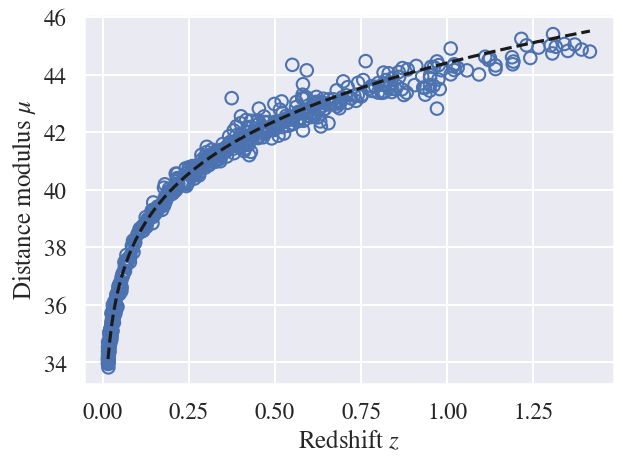

In [6]:
def plot_predfn():
    z_min,z_max = min(Z), max(Z)
    Z_space = np.linspace(z_min, z_max, 300)

    def pred_fn(zz, H_, q_):
        y_ = 5 * np.log10((c/H_) * (zz + (1/2) * (1-q_)*zz**2)) + 25
        return y_

    fig, ax = plt.subplots()
    pfn = np.vectorize(pred_fn)

    ax.plot(Z_space, pfn(Z_space, H0_map, q0_map), '--k')
    ax.scatter(Z, distance_modulus, facecolors='none', edgecolors='b')
    ax.set_xlabel(r"Redshift $z$")
    ax.set_ylabel(r"Distance modulus $\mu$")
    fig.tight_layout()
    fig.savefig("z_prediction.png", dpi=200)
    
plot_predfn()

In [7]:
with model:
    trace_NUTS = pm.sample(3000, cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [H0, q0, sigma2]


ValueError: Not enough samples to build a trace.

In [ ]:
with model:
    print(az.summary(trace_NUTS, kind='stats', round_to=2,hdi_prob=0.9))
    fig, axs = plt.subplots(3,2,figsize=(8,5))
    az.plot_trace(trace_NUTS, axes=axs)
    axs2 = az.plot_posterior(trace_NUTS,figsize=(12, 5),hdi_prob=0.9);

for i in range(2):
    axs[0,i].set_title(r"$H_0$")
    axs2[0].set_title(r"$H_0$")
    axs[1,i].set_title(r"$q_0$")
    axs2[1].set_title(r"$q_0$")
    axs[2,i].set_title(r"$\sigma^2$")
    axs2[2].set_title(r"$\sigma^2$")

fig.tight_layout()
fig.savefig("pymc_pdfs.png", dpi=150)

In [ ]:

H0_samples = np.hstack([trace_NUTS.posterior['H0'][k] for k in range(len(trace_NUTS.posterior['H0']))])
q0_samples = np.hstack([trace_NUTS.posterior['q0'][k] for k in range(len(trace_NUTS.posterior['q0']))])
sigma_samples = np.hstack([trace_NUTS.posterior['sigma2'][k] for k in range(len(trace_NUTS.posterior['sigma2']))])
samples = np.vstack((H0_samples,q0_samples)).T

fig_corner = corner.corner(samples,labels =[r'$H_0$',r'$q_0$'], show_titles=True)

for ax in fig_corner.get_axes():
    ax.tick_params(axis='both', labelsize=10)
fig_corner.savefig("H0q0_corner.png", dpi=150)


In [ ]:
# 2nd task optimization of log likelihood 
# using all z values with scipy minimize, Nelder mead

D = distance_fn(distance_modulus)
D_e = distance_fn(distance_modulus_e)

W_mat_sum = np.sum(1/D_e **2)
# Weight matrix
W_mat = np.diag(1/D_e**2 / W_mat_sum)

H0_ = 7e4

# Models returns prop to -log likelihood
# use Bound-Constrained minimization

def model_lambda(theta):
    M, L = theta
    Ez = lambda z: 1 / np.sqrt(M * (1 + z)**3 + L)
    D_ML_fn = lambda z: (c/H0_)*(1 + z) * scipy.integrate.quad(Ez, 0, z)[0]
    D_ML = np.vectorize(D_ML_fn)(Z)    
    return (1/2) * (D - D_ML).T @ W_mat @ (D - D_ML)

def model_w(theta):
    M, L, w = theta
    Ez = lambda z: 1 / np.sqrt(M * (1 + z)**3 + L*(1 + z)**(3*(1+w)))
    D_ML_fn = lambda z: (c/H0_)*(1 + z) * scipy.integrate.quad(Ez, 0, z)[0]
    D_ML = np.vectorize(D_ML_fn)(Z)  
    return (1/2) * (D - D_ML).T @ W_mat @ (D - D_ML)    

res_lambda = scipy.optimize.minimize(
    fun=model_lambda,
    x0=np.array([1, 1]), method='Nelder-Mead',
    options={'disp': True, 'maxiter':1000, 'fatol': 1e-7})
M_l, L_l = res_lambda.x
print(M_l, L_l)

In [ ]:
res_w = scipy.optimize.minimize(
    fun=model_w,
    x0=np.array([0.3, 0.7, -1]), method='Nelder-Mead',
    options={'disp': True, 'maxiter':300, 'fatol': 1e-7})
M_w, L_w, w = res_w.x
print(M_w, L_w, w)

def inf_criteria(log_likelihood, dims):
    BIC = 2 * log_likelihood - N_p * np.log(dims)
    AIC = 2 * log_likelihood - 2 * N_p
    return AIC, BIC

AIC_l, BIC_l = inf_criteria(-model_lambda([M_l, L_l]), 2)
AIC_w, BIC_w = inf_criteria(-model_w([M_w, L_w, w]), 3)

min_ic = -min(AIC_l, BIC_l, AIC_w, BIC_w)
AIC_l, BIC_l = AIC_l + min_ic + 1, BIC_l + min_ic + 1
AIC_w, BIC_w = AIC_w + min_ic + 1, BIC_w + min_ic + 1
print("Normalised IC")
print(f"Lambda: AIC: {AIC_l:.3f}, BIC: {BIC_l:.3f}")
print(f"w: AIC: {AIC_w:.3f}, BIC: {BIC_w:.3f}")

In [ ]:
# Normal prior mu = 0.5, 0.5, s2 = 1., 1.
def logprior_lambda(theta):
    M, L = theta
    if M > 1 or L > 1:
        return -np.inf
    if M < 0 or L < 0:
        return -np.inf
    return 0

# -model_lambda due to it being -log likelihood
def logposterior_lambda(theta):
    return logprior_lambda(theta) - model_lambda(theta)

theta_0 = [M_l, L_l]
Nwalker = 250
p0 = [theta_0+1.e-4*np.random.randn(N_p) for i in range(Nwalker)]

In [ ]:
from multiprocessing import Pool
with Pool() as pool:
    sampler = emcee.EnsembleSampler(Nwalker,N_p,logposterior_lambda, pool=pool)
    pos,prob,state = sampler.run_mcmc(p0, 5000, progress=True)

In [ ]:
fig_corner = corner.corner(
    sampler.flatchain,
    labels =[r"$\Omega_{M,0}$", r"$\Omega_{\Lambda,0}$"],
    show_titles=True)

for ax in fig_corner.get_axes():
    ax.tick_params(axis='both', labelsize=10)
fig_corner.savefig("omega_corner.png", dpi=150)